In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from joblib import dump

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Size of data split for testing
train_size = 0.9

In [6]:
# Train-Test split
split = int(len(data) * train_size)

train = data.to_numpy()[:split]
test = data.to_numpy()[split:]

In [7]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
train_norm = normaliser.fit_transform(train)
test_norm = normaliser.transform(test)

In [8]:
# Normalised train chunks
X_train = np.array([train_norm[i : i + backlook].copy() for i in range(len(train) - backlook)])
Y_train = np.array([train_norm[:,3][i + backlook].copy() for i in range(len(train) - backlook)])
Y_train = np.expand_dims(Y_train, -1)

In [9]:
# Normalised test chunks
X_test = np.array([test_norm[i : i + backlook].copy() for i in range(len(test) - backlook)])
Y_test = np.array([test_norm[:,3][i + backlook].copy() for i in range(len(test) - backlook)])
Y_test = np.expand_dims(Y_test, -1)

In [10]:
# Y raw data
next_day_open_values = np.array([train[:,3][i + backlook].copy() for i in range(len(train) - backlook)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.33316742],
       [0.32308841],
       [0.33553164],
       ...,
       [0.5127232 ],
       [0.52865053],
       [0.52653518]])

In [11]:
# Save scalers for future use
dump(normaliser, './normalisers/x_normaliser.joblib')
dump(y_normaliser, './normalisers/y_normaliser.joblib')

['./normalisers/y_normaliser.joblib']

# Model selection

##### Model constructor

In [12]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [13]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [14]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [15]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 735us/step - loss: 0.0634 - val_loss: 0.0079
Epoch 2/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0045 - val_loss: 0.0048
Epoch 3/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 4/24
4143/4143 [==============================] - 2s 479us/step - loss: 0.0013 - val_loss: 7.1330e-04
Epoch 5/24
4143/4143 [==============================] - 2s 482us/step - loss: 9.8912e-04 - val_loss: 0.0012
Epoch 6/24
4143/4143 [==============================] - 2s 477us/step - loss: 8.1646e-04 - val_loss: 0.0011
Epoch 7/24
4143/4143 [==============================] - 2s 478us/step - loss: 7.3967e-04 - val_loss: 9.1729e-04
Epoch 8/24
4143/4143 [==============================] - 2s 473us/step 

Epoch 20/24
4143/4143 [==============================] - 2s 489us/step - loss: 5.2531e-04 - val_loss: 5.1930e-04
Epoch 21/24
4143/4143 [==============================] - 2s 481us/step - loss: 5.2010e-04 - val_loss: 4.6965e-04
Epoch 22/24
4143/4143 [==============================] - 2s 474us/step - loss: 5.3594e-04 - val_loss: 4.5649e-04
Epoch 23/24
4143/4143 [==============================] - 2s 472us/step - loss: 5.1477e-04 - val_loss: 4.4169e-04
Epoch 24/24
4143/4143 [==============================] - 2s 473us/step - loss: 5.0015e-04 - val_loss: 4.2937e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 637us/step - loss: 0.0539 - val_loss: 0.0031
Epoch 2/24
4143/4143 [==============================] - 2s 470us/step - loss: 0.0051 - val_loss: 0.0049
Epoch 3/24
4143/4143 [==============================] - 2s 473us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 4/24
4143/4143 [==============================] - 2s 477us/step - loss

Epoch 21/24
4143/4143 [==============================] - 2s 495us/step - loss: 0.0015 - val_loss: 4.7053e-04
Epoch 22/24
4143/4143 [==============================] - 2s 489us/step - loss: 0.0015 - val_loss: 4.8874e-04
Epoch 23/24
4143/4143 [==============================] - 2s 490us/step - loss: 0.0015 - val_loss: 4.7900e-04
Epoch 24/24
4143/4143 [==============================] - 2s 493us/step - loss: 0.0015 - val_loss: 4.8788e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 764us/step - loss: 0.3459 - val_loss: 0.0020
Epoch 2/24
4143/4143 [==============================] - 2s 519us/step - loss: 0.0183 - val_loss: 6.9437e-04
Epoch 3/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0086 - val_loss: 8.9956e-04
Epoch 4/24
4143/4143 [==============================] - 2s 521us/step - loss: 0.0039 - val_loss: 0.0051
Epoch 5/24
4143/4143 [==============================] - 2s 513us/step - loss: 0.0028 - val_lo

4143/4143 [==============================] - 2s 513us/step - loss: 0.0172 - val_loss: 0.0073
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 3s 767us/step - loss: 0.0655 - val_loss: 0.0386
Epoch 2/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0629 - val_loss: 0.0395
Epoch 3/24
4143/4143 [==============================] - 2s 510us/step - loss: 0.0605 - val_loss: 0.0304
Epoch 4/24
4143/4143 [==============================] - 2s 516us/step - loss: 0.0581 - val_loss: 0.0216
Epoch 5/24
4143/4143 [==============================] - 2s 511us/step - loss: 0.0561 - val_loss: 0.0514
Epoch 6/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0540 - val_loss: 0.0332
Epoch 7/24
4143/4143 [==============================] - 2s 514us/step - loss: 0.0517 - val_loss: 0.0200
Epoch 8/24
4143/4143 [==============================] - 2s 518us/step - loss: 0.0493 - val_loss: 0.0228
Epoch 9/24
4143/4143 [======

4143/4143 [==============================] - 3s 774us/step - loss: 0.0749 - val_loss: 0.0075
Epoch 2/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0071 - val_loss: 0.0047
Epoch 3/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0037 - val_loss: 0.0027
Epoch 4/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0015 - val_loss: 8.7069e-04
Epoch 5/24
4143/4143 [==============================] - 2s 481us/step - loss: 9.4664e-04 - val_loss: 0.0016
Epoch 6/24
4143/4143 [==============================] - 2s 486us/step - loss: 7.7080e-04 - val_loss: 5.6305e-04
Epoch 7/24
4143/4143 [==============================] - 2s 478us/step - loss: 7.0955e-04 - val_loss: 8.4091e-04
Epoch 8/24
4143/4143 [==============================] - 2s 477us/step - loss: 6.8039e-04 - val_loss: 6.0852e-04
Epoch 9/24
4143/4143 [==============================] - 2s 483us/step - loss: 6.6821e-04 - val_loss: 6.5701e-04
Epoch 10/24
4143/4143 [============

Epoch 4/24
4143/4143 [==============================] - 2s 422us/step - loss: 0.0045 - val_loss: 9.5024e-04
Epoch 5/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 6/24
4143/4143 [==============================] - 2s 424us/step - loss: 0.0017 - val_loss: 0.0019
Epoch 7/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0016 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0016 - val_loss: 0.0014
Epoch 9/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0016 - val_loss: 8.3303e-04
Epoch 10/24
4143/4143 [==============================] - 2s 426us/step - loss: 0.0017 - val_loss: 0.0030
Epoch 11/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0017 - val_loss: 8.7241e-04
Epoch 12/24
4143/4143 [==============================] - 2s 426us/step - loss: 0.0015 - val_loss: 8.2672e-04
Epoch 13/24
4143/4143 [======================

4143/4143 [==============================] - 2s 524us/step - loss: 0.0070 - val_loss: 0.0167
Epoch 9/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0090 - val_loss: 0.0141
Epoch 10/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0091 - val_loss: 0.0033
Epoch 11/24
4143/4143 [==============================] - 2s 524us/step - loss: 0.0047 - val_loss: 0.0331
Epoch 12/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0112 - val_loss: 8.0342e-04
Epoch 13/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0042 - val_loss: 0.0300
Epoch 14/24
4143/4143 [==============================] - 2s 530us/step - loss: 0.0072 - val_loss: 5.1002e-04
Epoch 15/24
4143/4143 [==============================] - 2s 525us/step - loss: 0.0051 - val_loss: 0.0204
Epoch 16/24
4143/4143 [==============================] - 2s 525us/step - loss: 0.0048 - val_loss: 7.4507e-04
Epoch 17/24
4143/4143 [==============================] -

4143/4143 [==============================] - 2s 477us/step - loss: 7.9977e-04 - val_loss: 9.5113e-04
Epoch 10/24
4143/4143 [==============================] - 2s 475us/step - loss: 7.6807e-04 - val_loss: 8.5873e-04
Epoch 11/24
4143/4143 [==============================] - 2s 476us/step - loss: 7.4159e-04 - val_loss: 6.9773e-04
Epoch 12/24
4143/4143 [==============================] - 2s 476us/step - loss: 7.2481e-04 - val_loss: 7.2135e-04
Epoch 13/24
4143/4143 [==============================] - 2s 474us/step - loss: 7.0303e-04 - val_loss: 6.7617e-04
Epoch 14/24
4143/4143 [==============================] - 2s 474us/step - loss: 6.6636e-04 - val_loss: 6.4693e-04
Epoch 15/24
4143/4143 [==============================] - 2s 487us/step - loss: 6.4058e-04 - val_loss: 6.2092e-04
Epoch 16/24
4143/4143 [==============================] - 2s 475us/step - loss: 6.2111e-04 - val_loss: 6.5227e-04
Epoch 17/24
4143/4143 [==============================] - 2s 476us/step - loss: 6.0276e-04 - val_loss: 5.9101

4143/4143 [==============================] - 2s 428us/step - loss: 0.0217 - val_loss: 0.1804
Epoch 16/24
4143/4143 [==============================] - 2s 410us/step - loss: 0.1224 - val_loss: 0.1628
Epoch 17/24
4143/4143 [==============================] - 2s 410us/step - loss: 0.0200 - val_loss: 0.0013
Epoch 18/24
4143/4143 [==============================] - 2s 406us/step - loss: 9.7902e-04 - val_loss: 5.8961e-04
Epoch 19/24
4143/4143 [==============================] - 2s 420us/step - loss: 9.8649e-04 - val_loss: 0.0020
Epoch 20/24
4143/4143 [==============================] - 2s 416us/step - loss: 7.9548e-04 - val_loss: 0.0011
Epoch 21/24
4143/4143 [==============================] - 2s 411us/step - loss: 8.5045e-04 - val_loss: 9.0587e-04
Epoch 22/24
4143/4143 [==============================] - 2s 416us/step - loss: 0.0061 - val_loss: 0.0225
Epoch 23/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0044 - val_loss: 5.5784e-04
Epoch 24/24
4143/4143 [================

Epoch 19/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0360 - val_loss: 0.0025
Epoch 20/24
4143/4143 [==============================] - 2s 416us/step - loss: 8.8760e-04 - val_loss: 9.3758e-04
Epoch 21/24
4143/4143 [==============================] - 2s 409us/step - loss: 6.6164e-04 - val_loss: 0.0012
Epoch 22/24
4143/4143 [==============================] - 2s 420us/step - loss: 6.3712e-04 - val_loss: 8.7493e-04
Epoch 23/24
4143/4143 [==============================] - 2s 412us/step - loss: 6.3741e-04 - val_loss: 0.0026
Epoch 24/24
4143/4143 [==============================] - 2s 414us/step - loss: 0.0026 - val_loss: 0.0105

GENERATION 3

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 4s 1ms/step - loss: 0.0759 - val_loss: 0.0225
Epoch 2/24
4143/4143 [==============================] - 2s 476us/step - loss: 0.0082 - val_loss: 0.0019
Epoch 3/24
4143/4143 [==============================] - 2s 478us/step - loss: 

4143/4143 [==============================] - 2s 474us/step - loss: 8.4270e-04 - val_loss: 7.1789e-04
Epoch 21/24
4143/4143 [==============================] - 2s 485us/step - loss: 8.1701e-04 - val_loss: 7.3230e-04
Epoch 22/24
4143/4143 [==============================] - 2s 475us/step - loss: 7.9994e-04 - val_loss: 7.1470e-04
Epoch 23/24
4143/4143 [==============================] - 2s 474us/step - loss: 7.8499e-04 - val_loss: 7.0233e-04
Epoch 24/24
4143/4143 [==============================] - 2s 476us/step - loss: 7.7271e-04 - val_loss: 7.1065e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 5s 1ms/step - loss: 0.0864 - val_loss: 0.0391
Epoch 2/24
4143/4143 [==============================] - 2s 479us/step - loss: 0.0540 - val_loss: 0.0044
Epoch 3/24
4143/4143 [==============================] - 2s 476us/step - loss: 0.0294 - val_loss: 0.0028
Epoch 4/24
4143/4143 [==============================] - 2s 475us/step - loss: 0.0232 - val

4143/4143 [==============================] - 2s 534us/step - loss: 0.0046 - val_loss: 0.0215
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 5s 1ms/step - loss: 0.1691 - val_loss: 0.0407
Epoch 2/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0688 - val_loss: 0.0121
Epoch 3/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0721 - val_loss: 0.0217
Epoch 4/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0659 - val_loss: 0.0399
Epoch 5/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0649 - val_loss: 0.0479
Epoch 6/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0651 - val_loss: 0.0423
Epoch 7/24
4143/4143 [==============================] - 2s 537us/step - loss: 0.0647 - val_loss: 0.0382
Epoch 8/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0646 - val_loss: 0.0387
Epoch 9/24
4143/4143 [========

4143/4143 [==============================] - 2s 476us/step - loss: 0.0077 - val_loss: 0.0043
Epoch 5/24
4143/4143 [==============================] - 2s 482us/step - loss: 0.0045 - val_loss: 0.0011
Epoch 6/24
4143/4143 [==============================] - 2s 478us/step - loss: 0.0025 - val_loss: 9.0097e-04
Epoch 7/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0021 - val_loss: 0.0014
Epoch 8/24
4143/4143 [==============================] - 2s 476us/step - loss: 0.0017 - val_loss: 0.0015
Epoch 9/24
4143/4143 [==============================] - 2s 480us/step - loss: 0.0016 - val_loss: 0.0010
Epoch 10/24
4143/4143 [==============================] - 2s 476us/step - loss: 0.0015 - val_loss: 0.0010
Epoch 11/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0014 - val_loss: 0.0013
Epoch 12/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 13/24
4143/4143 [==============================] - 2s 476us/st

Epoch 7/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 8/24
4143/4143 [==============================] - 2s 498us/step - loss: 0.0039 - val_loss: 6.5130e-04
Epoch 9/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0024 - val_loss: 0.0107
Epoch 10/24
4143/4143 [==============================] - 2s 504us/step - loss: 0.0051 - val_loss: 0.0020
Epoch 11/24
4143/4143 [==============================] - 2s 499us/step - loss: 0.0018 - val_loss: 0.0053
Epoch 12/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0038 - val_loss: 0.0041
Epoch 13/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0025 - val_loss: 5.3949e-04
Epoch 14/24
4143/4143 [==============================] - 2s 500us/step - loss: 0.0018 - val_loss: 0.0083
Epoch 15/24
4143/4143 [==============================] - 2s 498us/step - loss: 0.0032 - val_loss: 6.2616e-04
Epoch 16/24
4143/4143 [=======================

4143/4143 [==============================] - 2s 549us/step - loss: 0.0120 - val_loss: 0.0125
Epoch 12/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0094 - val_loss: 0.0080
Epoch 13/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0068 - val_loss: 0.0103
Epoch 14/24
4143/4143 [==============================] - 2s 554us/step - loss: 0.0102 - val_loss: 0.0147
Epoch 15/24
4143/4143 [==============================] - 2s 554us/step - loss: 0.0122 - val_loss: 0.0184
Epoch 16/24
4143/4143 [==============================] - 2s 557us/step - loss: 0.0128 - val_loss: 0.0206
Epoch 17/24
4143/4143 [==============================] - 2s 555us/step - loss: 0.0131 - val_loss: 0.0053
Epoch 18/24
4143/4143 [==============================] - 2s 550us/step - loss: 0.0055 - val_loss: 0.0116
Epoch 19/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0088 - val_loss: 0.0116
Epoch 20/24
4143/4143 [==============================] - 2s 550us/s

4143/4143 [==============================] - 2s 506us/step - loss: 6.6606e-04 - val_loss: 9.2062e-04
Epoch 16/24
4143/4143 [==============================] - 2s 518us/step - loss: 6.7446e-04 - val_loss: 7.4573e-04
Epoch 17/24
4143/4143 [==============================] - 2s 508us/step - loss: 7.2747e-04 - val_loss: 9.9894e-04
Epoch 18/24
4143/4143 [==============================] - 2s 511us/step - loss: 6.8169e-04 - val_loss: 5.3461e-04
Epoch 19/24
4143/4143 [==============================] - 2s 506us/step - loss: 6.1019e-04 - val_loss: 8.8019e-04
Epoch 20/24
4143/4143 [==============================] - 2s 509us/step - loss: 6.4031e-04 - val_loss: 5.4415e-04
Epoch 21/24
4143/4143 [==============================] - 2s 509us/step - loss: 5.8063e-04 - val_loss: 6.8925e-04
Epoch 22/24
4143/4143 [==============================] - 2s 504us/step - loss: 5.6726e-04 - val_loss: 5.9542e-04
Epoch 23/24
4143/4143 [==============================] - 2s 512us/step - loss: 5.3422e-04 - val_loss: 4.8331

4143/4143 [==============================] - 2s 480us/step - loss: 6.1494e-04 - val_loss: 5.5596e-04
Epoch 16/24
4143/4143 [==============================] - 2s 496us/step - loss: 6.0936e-04 - val_loss: 5.1783e-04
Epoch 17/24
4143/4143 [==============================] - 2s 478us/step - loss: 6.0602e-04 - val_loss: 5.4829e-04
Epoch 18/24
4143/4143 [==============================] - 2s 481us/step - loss: 6.0311e-04 - val_loss: 5.1727e-04
Epoch 19/24
4143/4143 [==============================] - 2s 480us/step - loss: 5.9820e-04 - val_loss: 5.1623e-04
Epoch 20/24
4143/4143 [==============================] - 2s 485us/step - loss: 5.9548e-04 - val_loss: 5.3126e-04
Epoch 21/24
4143/4143 [==============================] - 2s 485us/step - loss: 5.9169e-04 - val_loss: 5.0792e-04
Epoch 22/24
4143/4143 [==============================] - 2s 478us/step - loss: 5.8923e-04 - val_loss: 5.3256e-04
Epoch 23/24
4143/4143 [==============================] - 2s 483us/step - loss: 5.8527e-04 - val_loss: 4.9808

Epoch 19/24
4143/4143 [==============================] - 3s 620us/step - loss: 0.0032 - val_loss: 6.0479e-04
Epoch 20/24
4143/4143 [==============================] - 3s 623us/step - loss: 0.0030 - val_loss: 6.1106e-04
Epoch 21/24
4143/4143 [==============================] - 3s 617us/step - loss: 0.0033 - val_loss: 0.0012
Epoch 22/24
4143/4143 [==============================] - 3s 621us/step - loss: 0.0030 - val_loss: 6.4762e-04
Epoch 23/24
4143/4143 [==============================] - 3s 625us/step - loss: 0.0030 - val_loss: 6.7137e-04
Epoch 24/24
4143/4143 [==============================] - 3s 619us/step - loss: 0.0028 - val_loss: 6.3998e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 8s 2ms/step - loss: 9.3405 - val_loss: 0.0121
Epoch 2/24
4143/4143 [==============================] - 3s 632us/step - loss: 0.0238 - val_loss: 0.0014
Epoch 3/24
4143/4143 [==============================] - 3s 616us/step - loss: 0.0076 - val_loss: 

4143/4143 [==============================] - 2s 483us/step - loss: 4.9297e-04 - val_loss: 4.2799e-04
Epoch 23/24
4143/4143 [==============================] - 2s 480us/step - loss: 4.7918e-04 - val_loss: 4.1646e-04
Epoch 24/24
4143/4143 [==============================] - 2s 479us/step - loss: 4.6571e-04 - val_loss: 4.2329e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 8s 2ms/step - loss: 0.0655 - val_loss: 0.0139
Epoch 2/24
4143/4143 [==============================] - 2s 481us/step - loss: 0.0075 - val_loss: 7.6397e-04
Epoch 3/24
4143/4143 [==============================] - 2s 479us/step - loss: 0.0038 - val_loss: 6.8847e-04
Epoch 4/24
4143/4143 [==============================] - 2s 480us/step - loss: 0.0016 - val_loss: 5.8637e-04
Epoch 5/24
4143/4143 [==============================] - 2s 484us/step - loss: 9.6951e-04 - val_loss: 0.0010
Epoch 6/24
4143/4143 [==============================] - 2s 480us/step - loss: 8.1201e-04 - v

4143/4143 [==============================] - 2s 376us/step - loss: 5.9045e-04 - val_loss: 5.5874e-04
Epoch 23/24
4143/4143 [==============================] - 2s 376us/step - loss: 5.8451e-04 - val_loss: 5.1085e-04
Epoch 24/24
4143/4143 [==============================] - 2s 379us/step - loss: 5.7968e-04 - val_loss: 5.6032e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 7s 2ms/step - loss: 0.8711 - val_loss: 0.0265
Epoch 2/24
4143/4143 [==============================] - 1s 341us/step - loss: 0.0162 - val_loss: 0.0359
Epoch 3/24
4143/4143 [==============================] - 1s 340us/step - loss: 0.0140 - val_loss: 0.0038
Epoch 4/24
4143/4143 [==============================] - 1s 338us/step - loss: 0.0029 - val_loss: 8.8498e-04
Epoch 5/24
4143/4143 [==============================] - 1s 338us/step - loss: 0.0022 - val_loss: 0.0106
Epoch 6/24
4143/4143 [==============================] - 1s 342us/step - loss: 0.0041 - val_loss: 0.0030


4143/4143 [==============================] - 9s 2ms/step - loss: 0.0582 - val_loss: 0.0033
Epoch 2/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0057 - val_loss: 0.0021
Epoch 3/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0076 - val_loss: 0.0165
Epoch 4/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0064 - val_loss: 0.0015
Epoch 5/24
4143/4143 [==============================] - 2s 443us/step - loss: 0.0066 - val_loss: 0.0122
Epoch 6/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0054 - val_loss: 8.8108e-04
Epoch 7/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0039 - val_loss: 0.0065
Epoch 8/24
4143/4143 [==============================] - 2s 443us/step - loss: 0.0064 - val_loss: 0.0048
Epoch 9/24
4143/4143 [==============================] - 2s 444us/step - loss: 0.0064 - val_loss: 0.0063
Epoch 10/24
4143/4143 [==============================] - 2s 442us/step - 

4143/4143 [==============================] - 2s 487us/step - loss: 6.3833e-04 - val_loss: 5.6010e-04
Epoch 6/24
4143/4143 [==============================] - 2s 491us/step - loss: 6.1620e-04 - val_loss: 4.5252e-04
Epoch 7/24
4143/4143 [==============================] - 2s 494us/step - loss: 5.8208e-04 - val_loss: 4.6505e-04
Epoch 8/24
4143/4143 [==============================] - 2s 492us/step - loss: 5.7084e-04 - val_loss: 4.9161e-04
Epoch 9/24
4143/4143 [==============================] - 2s 487us/step - loss: 5.6746e-04 - val_loss: 4.7311e-04
Epoch 10/24
4143/4143 [==============================] - 2s 487us/step - loss: 5.6266e-04 - val_loss: 5.0729e-04
Epoch 11/24
4143/4143 [==============================] - 2s 485us/step - loss: 5.6130e-04 - val_loss: 4.5137e-04
Epoch 12/24
4143/4143 [==============================] - 2s 488us/step - loss: 5.5608e-04 - val_loss: 4.4533e-04
Epoch 13/24
4143/4143 [==============================] - 2s 488us/step - loss: 5.6020e-04 - val_loss: 4.7217e-04

4143/4143 [==============================] - 2s 493us/step - loss: 0.0049 - val_loss: 0.0018
Epoch 9/24
4143/4143 [==============================] - 2s 498us/step - loss: 0.0016 - val_loss: 0.0086
Epoch 10/24
4143/4143 [==============================] - 2s 489us/step - loss: 0.0042 - val_loss: 0.0104
Epoch 11/24
4143/4143 [==============================] - 2s 491us/step - loss: 0.0054 - val_loss: 0.0011
Epoch 12/24
4143/4143 [==============================] - 2s 490us/step - loss: 0.0012 - val_loss: 0.0018
Epoch 13/24
4143/4143 [==============================] - 2s 487us/step - loss: 0.0019 - val_loss: 0.0058
Epoch 14/24
4143/4143 [==============================] - 2s 490us/step - loss: 0.0038 - val_loss: 0.0121
Epoch 15/24
4143/4143 [==============================] - 2s 492us/step - loss: 0.0053 - val_loss: 0.0070
Epoch 16/24
4143/4143 [==============================] - 2s 491us/step - loss: 0.0031 - val_loss: 0.0043
Epoch 17/24
4143/4143 [==============================] - 2s 493us/st

Epoch 13/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0116 - val_loss: 0.0139
Epoch 14/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0096 - val_loss: 0.0090
Epoch 15/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0073 - val_loss: 0.0060
Epoch 16/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0067 - val_loss: 0.0059
Epoch 17/24
4143/4143 [==============================] - 2s 532us/step - loss: 0.0063 - val_loss: 0.0100
Epoch 18/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0095 - val_loss: 0.0181
Epoch 19/24
4143/4143 [==============================] - 2s 540us/step - loss: 0.0084 - val_loss: 0.0028
Epoch 20/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0052 - val_loss: 0.0185
Epoch 21/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0085 - val_loss: 0.0101
Epoch 22/24
4143/4143 [==============================] 

4143/4143 [==============================] - 2s 509us/step - loss: 6.7812e-04 - val_loss: 7.0204e-04
Epoch 16/24
4143/4143 [==============================] - 2s 513us/step - loss: 6.7182e-04 - val_loss: 6.6213e-04
Epoch 17/24
4143/4143 [==============================] - 2s 514us/step - loss: 6.6550e-04 - val_loss: 6.7654e-04
Epoch 18/24
4143/4143 [==============================] - 2s 514us/step - loss: 6.5927e-04 - val_loss: 6.3232e-04
Epoch 19/24
4143/4143 [==============================] - 2s 510us/step - loss: 6.5310e-04 - val_loss: 6.3146e-04
Epoch 20/24
4143/4143 [==============================] - 2s 513us/step - loss: 6.4679e-04 - val_loss: 6.2557e-04
Epoch 21/24
4143/4143 [==============================] - 2s 519us/step - loss: 6.4140e-04 - val_loss: 6.2006e-04
Epoch 22/24
4143/4143 [==============================] - 2s 514us/step - loss: 6.3651e-04 - val_loss: 6.1444e-04
Epoch 23/24
4143/4143 [==============================] - 2s 513us/step - loss: 6.3240e-04 - val_loss: 6.0228

4143/4143 [==============================] - 2s 536us/step - loss: 0.0011 - val_loss: 6.2858e-04
Epoch 18/24
4143/4143 [==============================] - 2s 539us/step - loss: 0.0011 - val_loss: 5.4323e-04
Epoch 19/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.0011 - val_loss: 5.3020e-04
Epoch 20/24
4143/4143 [==============================] - 2s 531us/step - loss: 0.0011 - val_loss: 5.3261e-04
Epoch 21/24
4143/4143 [==============================] - 2s 538us/step - loss: 0.0010 - val_loss: 5.5286e-04
Epoch 22/24
4143/4143 [==============================] - 2s 532us/step - loss: 9.9540e-04 - val_loss: 5.7858e-04
Epoch 23/24
4143/4143 [==============================] - 2s 530us/step - loss: 0.0010 - val_loss: 4.9648e-04
Epoch 24/24
4143/4143 [==============================] - 2s 542us/step - loss: 9.8627e-04 - val_loss: 5.7820e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0541 -

4143/4143 [==============================] - 2s 536us/step - loss: 8.0968e-04 - val_loss: 7.6726e-04
Epoch 20/24
4143/4143 [==============================] - 2s 541us/step - loss: 7.5517e-04 - val_loss: 4.8016e-04
Epoch 21/24
4143/4143 [==============================] - 2s 537us/step - loss: 8.1996e-04 - val_loss: 7.8385e-04
Epoch 22/24
4143/4143 [==============================] - 2s 541us/step - loss: 7.5934e-04 - val_loss: 6.7908e-04
Epoch 23/24
4143/4143 [==============================] - 2s 534us/step - loss: 7.4717e-04 - val_loss: 4.7301e-04
Epoch 24/24
4143/4143 [==============================] - 2s 533us/step - loss: 7.4436e-04 - val_loss: 5.2780e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 13s 3ms/step - loss: 0.0512 - val_loss: 0.0483
Epoch 2/24
4143/4143 [==============================] - 2s 531us/step - loss: 0.0115 - val_loss: 0.0036
Epoch 3/24
4143/4143 [==============================] - 2s 534us/step - loss: 0.

Epoch 22/24
4143/4143 [==============================] - 2s 520us/step - loss: 4.6980e-04 - val_loss: 4.6185e-04
Epoch 23/24
4143/4143 [==============================] - 2s 521us/step - loss: 4.6141e-04 - val_loss: 4.2564e-04
Epoch 24/24
4143/4143 [==============================] - 2s 520us/step - loss: 4.6337e-04 - val_loss: 5.1440e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 14s 3ms/step - loss: 0.0598 - val_loss: 0.0213
Epoch 2/24
4143/4143 [==============================] - 3s 636us/step - loss: 0.0083 - val_loss: 0.0090
Epoch 3/24
4143/4143 [==============================] - 3s 641us/step - loss: 0.0040 - val_loss: 5.9102e-04
Epoch 4/24
4143/4143 [==============================] - 3s 637us/step - loss: 0.0022 - val_loss: 8.6207e-04
Epoch 5/24
4143/4143 [==============================] - 3s 636us/step - loss: 0.0020 - val_loss: 0.0013
Epoch 6/24
4143/4143 [==============================] - 3s 639us/step - loss: 0.0014 - 

Epoch 23/24
4143/4143 [==============================] - 2s 561us/step - loss: 7.2878e-04 - val_loss: 4.4580e-04
Epoch 24/24
4143/4143 [==============================] - 2s 558us/step - loss: 7.7331e-04 - val_loss: 4.4691e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 15s 4ms/step - loss: 0.0726 - val_loss: 0.0026
Epoch 2/24
4143/4143 [==============================] - 2s 561us/step - loss: 0.0093 - val_loss: 0.0091
Epoch 3/24
4143/4143 [==============================] - 2s 569us/step - loss: 0.0044 - val_loss: 7.0945e-04
Epoch 4/24
4143/4143 [==============================] - 2s 560us/step - loss: 0.0025 - val_loss: 0.0050
Epoch 5/24
4143/4143 [==============================] - 2s 565us/step - loss: 0.0020 - val_loss: 8.4359e-04
Epoch 6/24
4143/4143 [==============================] - 2s 567us/step - loss: 0.0015 - val_loss: 5.3767e-04
Epoch 7/24
4143/4143 [==============================] - 2s 559us/step - loss: 0.0015 - val_l

4143/4143 [==============================] - 15s 4ms/step - loss: 5.5708 - val_loss: 0.0313
Epoch 2/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0542 - val_loss: 0.0112
Epoch 3/24
4143/4143 [==============================] - 2s 410us/step - loss: 0.0406 - val_loss: 0.0069
Epoch 4/24
4143/4143 [==============================] - 2s 410us/step - loss: 0.0136 - val_loss: 0.0163
Epoch 5/24
4143/4143 [==============================] - 2s 407us/step - loss: 0.0217 - val_loss: 0.0069
Epoch 6/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0060 - val_loss: 0.0049
Epoch 7/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0049 - val_loss: 0.0031
Epoch 8/24
4143/4143 [==============================] - 2s 407us/step - loss: 0.0042 - val_loss: 0.0141
Epoch 9/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0062 - val_loss: 0.0045
Epoch 10/24
4143/4143 [==============================] - 2s 409us/step - los

Epoch 3/24
4143/4143 [==============================] - 2s 424us/step - loss: 0.0035 - val_loss: 0.0030
Epoch 4/24
4143/4143 [==============================] - 2s 426us/step - loss: 0.0020 - val_loss: 7.1224e-04
Epoch 5/24
4143/4143 [==============================] - 2s 426us/step - loss: 0.0015 - val_loss: 0.0016
Epoch 6/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0012 - val_loss: 0.0010
Epoch 7/24
4143/4143 [==============================] - 2s 423us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 8/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0010 - val_loss: 0.0010
Epoch 9/24
4143/4143 [==============================] - 2s 430us/step - loss: 9.5828e-04 - val_loss: 9.5432e-04
Epoch 10/24
4143/4143 [==============================] - 2s 426us/step - loss: 9.2029e-04 - val_loss: 9.9107e-04
Epoch 11/24
4143/4143 [==============================] - 2s 423us/step - loss: 8.8446e-04 - val_loss: 8.6735e-04
Epoch 12/24
4143/4143 [===========

Epoch 4/24
4143/4143 [==============================] - 2s 430us/step - loss: 352.1249 - val_loss: 177.4652
Epoch 5/24
4143/4143 [==============================] - 2s 422us/step - loss: 267.6964 - val_loss: 97.3579
Epoch 6/24
4143/4143 [==============================] - 2s 418us/step - loss: 226.5467 - val_loss: 62.3005
Epoch 7/24
4143/4143 [==============================] - 2s 424us/step - loss: 207.0816 - val_loss: 46.7381
Epoch 8/24
4143/4143 [==============================] - 2s 427us/step - loss: 191.2594 - val_loss: 35.5735
Epoch 9/24
4143/4143 [==============================] - 2s 424us/step - loss: 171.9282 - val_loss: 16.8770
Epoch 10/24
4143/4143 [==============================] - 2s 423us/step - loss: 151.4811 - val_loss: 8.4308
Epoch 11/24
4143/4143 [==============================] - 2s 422us/step - loss: 131.7682 - val_loss: 25.9787
Epoch 12/24
4143/4143 [==============================] - 2s 424us/step - loss: 113.1780 - val_loss: 19.3835
Epoch 13/24
4143/4143 [===========

4143/4143 [==============================] - 2s 547us/step - loss: 0.0050 - val_loss: 0.0020
Epoch 8/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0050 - val_loss: 0.0016
Epoch 9/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0047 - val_loss: 0.0014
Epoch 10/24
4143/4143 [==============================] - 2s 544us/step - loss: 0.0044 - val_loss: 0.0027
Epoch 11/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0045 - val_loss: 0.0024
Epoch 12/24
4143/4143 [==============================] - 2s 541us/step - loss: 0.0041 - val_loss: 0.0011
Epoch 13/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0041 - val_loss: 0.0021
Epoch 14/24
4143/4143 [==============================] - 2s 543us/step - loss: 0.0041 - val_loss: 0.0015
Epoch 15/24
4143/4143 [==============================] - 2s 542us/step - loss: 0.0039 - val_loss: 0.0022
Epoch 16/24
4143/4143 [==============================] - 2s 546us/ste

4143/4143 [==============================] - 2s 525us/step - loss: 6.3202e-04 - val_loss: 4.7299e-04
Epoch 10/24
4143/4143 [==============================] - 2s 521us/step - loss: 5.9301e-04 - val_loss: 4.5832e-04
Epoch 11/24
4143/4143 [==============================] - 2s 518us/step - loss: 5.7508e-04 - val_loss: 4.5258e-04
Epoch 12/24
4143/4143 [==============================] - 2s 521us/step - loss: 5.2896e-04 - val_loss: 4.5312e-04
Epoch 13/24
4143/4143 [==============================] - 2s 520us/step - loss: 5.1630e-04 - val_loss: 4.7889e-04
Epoch 14/24
4143/4143 [==============================] - 2s 516us/step - loss: 5.0614e-04 - val_loss: 4.7354e-04
Epoch 15/24
4143/4143 [==============================] - 2s 517us/step - loss: 4.9956e-04 - val_loss: 4.4011e-04
Epoch 16/24
4143/4143 [==============================] - 2s 518us/step - loss: 4.9419e-04 - val_loss: 5.5753e-04
Epoch 17/24
4143/4143 [==============================] - 2s 521us/step - loss: 5.1535e-04 - val_loss: 4.3967

4143/4143 [==============================] - 2s 437us/step - loss: 0.0092 - val_loss: 0.0082
Epoch 12/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0289 - val_loss: 6.7959e-04
Epoch 13/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0102 - val_loss: 0.0105
Epoch 14/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0083 - val_loss: 0.0232
Epoch 15/24
4143/4143 [==============================] - 2s 442us/step - loss: 0.0136 - val_loss: 0.0396
Epoch 16/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0070 - val_loss: 0.0038
Epoch 17/24
4143/4143 [==============================] - 2s 445us/step - loss: 0.0150 - val_loss: 0.0353
Epoch 18/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0054 - val_loss: 0.0072
Epoch 19/24
4143/4143 [==============================] - 2s 441us/step - loss: 0.0059 - val_loss: 0.0056
Epoch 20/24
4143/4143 [==============================] - 2s 438

4143/4143 [==============================] - 2s 443us/step - loss: 0.0300 - val_loss: 0.0405
Epoch 16/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0219 - val_loss: 0.0158
Epoch 17/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0203 - val_loss: 0.0188
Epoch 18/24
4143/4143 [==============================] - 2s 437us/step - loss: 0.0208 - val_loss: 0.0062
Epoch 19/24
4143/4143 [==============================] - 2s 438us/step - loss: 0.0191 - val_loss: 0.0330
Epoch 20/24
4143/4143 [==============================] - 2s 444us/step - loss: 0.0193 - val_loss: 0.0095
Epoch 21/24
4143/4143 [==============================] - 2s 443us/step - loss: 0.0134 - val_loss: 0.0296
Epoch 22/24
4143/4143 [==============================] - 2s 445us/step - loss: 0.0196 - val_loss: 0.0033
Epoch 23/24
4143/4143 [==============================] - 2s 440us/step - loss: 0.0156 - val_loss: 0.0380
Epoch 24/24
4143/4143 [==============================] - 2s 436us/s

4143/4143 [==============================] - 2s 415us/step - loss: 0.0013 - val_loss: 0.0010
Epoch 17/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0013 - val_loss: 0.0013
Epoch 18/24
4143/4143 [==============================] - 2s 415us/step - loss: 0.0013 - val_loss: 5.9584e-04
Epoch 19/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0012 - val_loss: 8.0022e-04
Epoch 20/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0012 - val_loss: 6.4600e-04
Epoch 21/24
4143/4143 [==============================] - 2s 417us/step - loss: 0.0011 - val_loss: 7.3253e-04
Epoch 22/24
4143/4143 [==============================] - 2s 415us/step - loss: 0.0011 - val_loss: 8.0843e-04
Epoch 23/24
4143/4143 [==============================] - 2s 415us/step - loss: 0.0011 - val_loss: 8.3304e-04
Epoch 24/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0011 - val_loss: 0.0010
Train on 4143 samples, validate on 461 samp

4143/4143 [==============================] - 2s 412us/step - loss: 0.0012 - val_loss: 5.5067e-04
Epoch 20/24
4143/4143 [==============================] - 2s 419us/step - loss: 0.0013 - val_loss: 5.1741e-04
Epoch 21/24
4143/4143 [==============================] - 2s 418us/step - loss: 0.0012 - val_loss: 5.7456e-04
Epoch 22/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0011 - val_loss: 7.8317e-04
Epoch 23/24
4143/4143 [==============================] - 2s 415us/step - loss: 0.0012 - val_loss: 5.6090e-04
Epoch 24/24
4143/4143 [==============================] - 2s 417us/step - loss: 0.0012 - val_loss: 5.8950e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 22s 5ms/step - loss: 1.0499 - val_loss: 0.1158
Epoch 2/24
4143/4143 [==============================] - 2s 515us/step - loss: 0.1125 - val_loss: 0.0568
Epoch 3/24
4143/4143 [==============================] - 2s 529us/step - loss: 0.0722 - val_loss: 0.0775


4143/4143 [==============================] - 2s 363us/step - loss: 0.0013 - val_loss: 8.8343e-04
Epoch 23/24
4143/4143 [==============================] - 2s 363us/step - loss: 0.0013 - val_loss: 6.8521e-04
Epoch 24/24
4143/4143 [==============================] - 1s 362us/step - loss: 0.0013 - val_loss: 7.3732e-04

GENERATION 13

Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 22s 5ms/step - loss: 0.0637 - val_loss: 0.0108
Epoch 2/24
4143/4143 [==============================] - 2s 391us/step - loss: 0.0065 - val_loss: 0.0044
Epoch 3/24
4143/4143 [==============================] - 2s 390us/step - loss: 0.0033 - val_loss: 0.0016
Epoch 4/24
4143/4143 [==============================] - 2s 388us/step - loss: 0.0016 - val_loss: 0.0036
Epoch 5/24
4143/4143 [==============================] - 2s 406us/step - loss: 0.0013 - val_loss: 0.0011
Epoch 6/24
4143/4143 [==============================] - 2s 386us/step - loss: 9.9477e-04 - val_loss: 5.

4143/4143 [==============================] - 2s 575us/step - loss: 7.2985e-04 - val_loss: 5.3601e-04
Epoch 23/24
4143/4143 [==============================] - 2s 577us/step - loss: 6.1943e-04 - val_loss: 5.7909e-04
Epoch 24/24
4143/4143 [==============================] - 2s 577us/step - loss: 6.1706e-04 - val_loss: 6.3226e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 24s 6ms/step - loss: 0.0826 - val_loss: 0.0033
Epoch 2/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0095 - val_loss: 0.0094
Epoch 3/24
4143/4143 [==============================] - 2s 570us/step - loss: 0.0066 - val_loss: 0.0023
Epoch 4/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0056 - val_loss: 0.0036
Epoch 5/24
4143/4143 [==============================] - 2s 580us/step - loss: 0.0032 - val_loss: 0.0089
Epoch 6/24
4143/4143 [==============================] - 2s 572us/step - loss: 0.0059 - val_loss: 0.0065
Epo

Epoch 2/24
4143/4143 [==============================] - 2s 556us/step - loss: 0.0153 - val_loss: 0.0248
Epoch 3/24
4143/4143 [==============================] - 2s 556us/step - loss: 0.0077 - val_loss: 0.0018
Epoch 4/24
4143/4143 [==============================] - 2s 547us/step - loss: 0.0060 - val_loss: 0.0043
Epoch 5/24
4143/4143 [==============================] - 2s 550us/step - loss: 0.0041 - val_loss: 0.0032
Epoch 6/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0058 - val_loss: 0.0058
Epoch 7/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0038 - val_loss: 0.0160
Epoch 8/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0062 - val_loss: 0.0043
Epoch 9/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0035 - val_loss: 6.9527e-04
Epoch 10/24
4143/4143 [==============================] - 2s 555us/step - loss: 0.0032 - val_loss: 0.0112
Epoch 11/24
4143/4143 [==============================] - 2s

4143/4143 [==============================] - 2s 557us/step - loss: 0.0648 - val_loss: 0.0349
Epoch 10/24
4143/4143 [==============================] - 2s 548us/step - loss: 0.0648 - val_loss: 0.0377
Epoch 11/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0647 - val_loss: 0.0407
Epoch 12/24
4143/4143 [==============================] - 2s 551us/step - loss: 0.0647 - val_loss: 0.0398
Epoch 13/24
4143/4143 [==============================] - 2s 550us/step - loss: 0.0647 - val_loss: 0.0398
Epoch 14/24
4143/4143 [==============================] - 2s 546us/step - loss: 0.0647 - val_loss: 0.0398
Epoch 15/24
4143/4143 [==============================] - 2s 545us/step - loss: 0.0647 - val_loss: 0.0372
Epoch 16/24
4143/4143 [==============================] - 2s 552us/step - loss: 0.0647 - val_loss: 0.0387
Epoch 17/24
4143/4143 [==============================] - 2s 549us/step - loss: 0.0647 - val_loss: 0.0389
Epoch 18/24
4143/4143 [==============================] - 2s 543us/s

Epoch 11/24
4143/4143 [==============================] - 2s 578us/step - loss: 8.7350e-04 - val_loss: 7.6617e-04
Epoch 12/24
4143/4143 [==============================] - 2s 574us/step - loss: 8.7234e-04 - val_loss: 7.6361e-04
Epoch 13/24
4143/4143 [==============================] - 2s 576us/step - loss: 8.4148e-04 - val_loss: 6.9380e-04
Epoch 14/24
4143/4143 [==============================] - 2s 580us/step - loss: 8.2771e-04 - val_loss: 6.9413e-04
Epoch 15/24
4143/4143 [==============================] - 2s 577us/step - loss: 8.2060e-04 - val_loss: 6.7449e-04
Epoch 16/24
4143/4143 [==============================] - 2s 575us/step - loss: 8.2325e-04 - val_loss: 8.0252e-04
Epoch 17/24
4143/4143 [==============================] - 2s 573us/step - loss: 7.8773e-04 - val_loss: 8.7672e-04
Epoch 18/24
4143/4143 [==============================] - 2s 579us/step - loss: 8.3256e-04 - val_loss: 0.0010
Epoch 19/24
4143/4143 [==============================] - 2s 576us/step - loss: 8.1290e-04 - val_loss

4143/4143 [==============================] - 2s 527us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 14/24
4143/4143 [==============================] - 2s 519us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 15/24
4143/4143 [==============================] - 2s 526us/step - loss: 0.0012 - val_loss: 0.0011
Epoch 16/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0012 - val_loss: 9.8725e-04
Epoch 17/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 18/24
4143/4143 [==============================] - 2s 520us/step - loss: 0.0011 - val_loss: 0.0010
Epoch 19/24
4143/4143 [==============================] - 2s 527us/step - loss: 0.0011 - val_loss: 7.1212e-04
Epoch 20/24
4143/4143 [==============================] - 2s 523us/step - loss: 0.0010 - val_loss: 9.2670e-04
Epoch 21/24
4143/4143 [==============================] - 2s 522us/step - loss: 0.0011 - val_loss: 0.0011
Epoch 22/24
4143/4143 [==============================] 

4143/4143 [==============================] - 2s 415us/step - loss: 5.0010e-04 - val_loss: 4.3539e-04
Epoch 17/24
4143/4143 [==============================] - 2s 413us/step - loss: 5.0470e-04 - val_loss: 4.8285e-04
Epoch 18/24
4143/4143 [==============================] - 2s 416us/step - loss: 4.8662e-04 - val_loss: 4.2976e-04
Epoch 19/24
4143/4143 [==============================] - 2s 418us/step - loss: 4.8350e-04 - val_loss: 4.2550e-04
Epoch 20/24
4143/4143 [==============================] - 2s 416us/step - loss: 4.8532e-04 - val_loss: 4.2080e-04
Epoch 21/24
4143/4143 [==============================] - 2s 413us/step - loss: 4.6923e-04 - val_loss: 4.4518e-04
Epoch 22/24
4143/4143 [==============================] - 2s 413us/step - loss: 4.7315e-04 - val_loss: 4.1183e-04
Epoch 23/24
4143/4143 [==============================] - 2s 417us/step - loss: 4.6212e-04 - val_loss: 4.0654e-04
Epoch 24/24
4143/4143 [==============================] - 2s 414us/step - loss: 4.5139e-04 - val_loss: 4.6706

4143/4143 [==============================] - 2s 426us/step - loss: 0.0020 - val_loss: 8.4627e-04
Epoch 19/24
4143/4143 [==============================] - 2s 432us/step - loss: 0.0020 - val_loss: 5.9858e-04
Epoch 20/24
4143/4143 [==============================] - 2s 430us/step - loss: 0.0019 - val_loss: 0.0015
Epoch 21/24
4143/4143 [==============================] - 2s 429us/step - loss: 0.0020 - val_loss: 5.4690e-04
Epoch 22/24
4143/4143 [==============================] - 2s 428us/step - loss: 0.0019 - val_loss: 7.9015e-04
Epoch 23/24
4143/4143 [==============================] - 2s 425us/step - loss: 0.0018 - val_loss: 7.7503e-04
Epoch 24/24
4143/4143 [==============================] - 2s 433us/step - loss: 0.0017 - val_loss: 6.4693e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 30s 7ms/step - loss: 0.0963 - val_loss: 0.0193
Epoch 2/24
4143/4143 [==============================] - 2s 557us/step - loss: 0.0120 - val_loss: 0.0074

4143/4143 [==============================] - 2s 553us/step - loss: 0.0021 - val_loss: 7.2811e-04
Epoch 22/24
4143/4143 [==============================] - 2s 556us/step - loss: 0.0021 - val_loss: 6.7711e-04
Epoch 23/24
4143/4143 [==============================] - 2s 566us/step - loss: 0.0021 - val_loss: 6.8802e-04
Epoch 24/24
4143/4143 [==============================] - 2s 551us/step - loss: 0.0020 - val_loss: 7.3699e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 32s 8ms/step - loss: 0.1991 - val_loss: 0.0073
Epoch 2/24
4143/4143 [==============================] - 2s 561us/step - loss: 0.0117 - val_loss: 0.0045
Epoch 3/24
4143/4143 [==============================] - 2s 555us/step - loss: 0.0074 - val_loss: 7.3477e-04
Epoch 4/24
4143/4143 [==============================] - 2s 553us/step - loss: 0.0038 - val_loss: 0.0021
Epoch 5/24
4143/4143 [==============================] - 2s 558us/step - loss: 0.0026 - val_loss: 5.4309e-04
Ep

4143/4143 [==============================] - 2s 524us/step - loss: 9.4390e-04 - val_loss: 6.0292e-04
Epoch 24/24
4143/4143 [==============================] - 2s 526us/step - loss: 8.9295e-04 - val_loss: 5.6653e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 33s 8ms/step - loss: 0.0476 - val_loss: 0.0089
Epoch 2/24
4143/4143 [==============================] - 2s 414us/step - loss: 0.0074 - val_loss: 0.0011
Epoch 3/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0031 - val_loss: 0.0016
Epoch 4/24
4143/4143 [==============================] - 2s 416us/step - loss: 0.0022 - val_loss: 0.0018
Epoch 5/24
4143/4143 [==============================] - 2s 412us/step - loss: 0.0012 - val_loss: 0.0024
Epoch 6/24
4143/4143 [==============================] - 2s 421us/step - loss: 0.0011 - val_loss: 7.6656e-04
Epoch 7/24
4143/4143 [==============================] - 2s 412us/step - loss: 8.9133e-04 - val_loss: 6.1164e-04


4143/4143 [==============================] - 34s 8ms/step - loss: 0.0812 - val_loss: 0.0328
Epoch 2/24
4143/4143 [==============================] - 2s 439us/step - loss: 0.0414 - val_loss: 0.0262
Epoch 3/24
4143/4143 [==============================] - 2s 433us/step - loss: 0.0365 - val_loss: 0.0199
Epoch 4/24
4143/4143 [==============================] - 2s 438us/step - loss: 0.0317 - val_loss: 0.0153
Epoch 5/24
4143/4143 [==============================] - 2s 431us/step - loss: 0.0269 - val_loss: 0.0132
Epoch 6/24
4143/4143 [==============================] - 2s 430us/step - loss: 0.0222 - val_loss: 0.0097
Epoch 7/24
4143/4143 [==============================] - 2s 434us/step - loss: 0.0179 - val_loss: 0.0092
Epoch 8/24
4143/4143 [==============================] - 2s 433us/step - loss: 0.0142 - val_loss: 0.0069
Epoch 9/24
4143/4143 [==============================] - 2s 436us/step - loss: 0.0113 - val_loss: 0.0038
Epoch 10/24
4143/4143 [==============================] - 2s 432us/step - los

Epoch 8/24
4143/4143 [==============================] - 2s 599us/step - loss: nan - val_loss: nan
Epoch 9/24
4143/4143 [==============================] - 2s 599us/step - loss: nan - val_loss: nan
Epoch 10/24
4143/4143 [==============================] - 2s 596us/step - loss: nan - val_loss: nan
Epoch 11/24
4143/4143 [==============================] - 3s 605us/step - loss: nan - val_loss: nan
Epoch 12/24
4143/4143 [==============================] - 2s 595us/step - loss: nan - val_loss: nan
Epoch 13/24
4143/4143 [==============================] - 2s 601us/step - loss: nan - val_loss: nan
Epoch 14/24
4143/4143 [==============================] - 2s 596us/step - loss: nan - val_loss: nan
Epoch 15/24
4143/4143 [==============================] - 2s 598us/step - loss: nan - val_loss: nan
Epoch 16/24
4143/4143 [==============================] - 2s 592us/step - loss: nan - val_loss: nan
Epoch 17/24
4143/4143 [==============================] - 3s 604us/step - loss: nan - val_loss: nan
Epoch 18/24


4143/4143 [==============================] - 2s 432us/step - loss: 5.5152e-04 - val_loss: 6.0154e-04
Epoch 15/24
4143/4143 [==============================] - 2s 435us/step - loss: 5.2718e-04 - val_loss: 5.4404e-04
Epoch 16/24
4143/4143 [==============================] - 2s 430us/step - loss: 5.1783e-04 - val_loss: 5.0319e-04
Epoch 17/24
4143/4143 [==============================] - 2s 436us/step - loss: 5.0195e-04 - val_loss: 4.5802e-04
Epoch 18/24
4143/4143 [==============================] - 2s 430us/step - loss: 4.9395e-04 - val_loss: 4.2989e-04
Epoch 19/24
4143/4143 [==============================] - 2s 430us/step - loss: 4.8412e-04 - val_loss: 4.3849e-04
Epoch 20/24
4143/4143 [==============================] - 2s 433us/step - loss: 4.8291e-04 - val_loss: 4.4230e-04
Epoch 21/24
4143/4143 [==============================] - 2s 442us/step - loss: 4.7477e-04 - val_loss: 4.1626e-04
Epoch 22/24
4143/4143 [==============================] - 2s 434us/step - loss: 4.7683e-04 - val_loss: 4.1090

4143/4143 [==============================] - 2s 435us/step - loss: 5.4444e-04 - val_loss: 6.1961e-04
Epoch 15/24
4143/4143 [==============================] - 2s 433us/step - loss: 5.2198e-04 - val_loss: 5.3070e-04
Epoch 16/24
4143/4143 [==============================] - 2s 430us/step - loss: 5.0557e-04 - val_loss: 4.2802e-04
Epoch 17/24
4143/4143 [==============================] - 2s 430us/step - loss: 5.0746e-04 - val_loss: 4.3409e-04
Epoch 18/24
4143/4143 [==============================] - 2s 436us/step - loss: 4.9351e-04 - val_loss: 4.9450e-04
Epoch 19/24
4143/4143 [==============================] - 2s 433us/step - loss: 4.8892e-04 - val_loss: 5.0194e-04
Epoch 20/24
4143/4143 [==============================] - 2s 435us/step - loss: 4.8278e-04 - val_loss: 4.1766e-04
Epoch 21/24
4143/4143 [==============================] - 2s 432us/step - loss: 4.7466e-04 - val_loss: 4.1358e-04
Epoch 22/24
4143/4143 [==============================] - 2s 436us/step - loss: 4.6738e-04 - val_loss: 4.1172

Epoch 15/24
4143/4143 [==============================] - 2s 584us/step - loss: 0.0014 - val_loss: 7.1514e-04
Epoch 16/24
4143/4143 [==============================] - 2s 577us/step - loss: 0.0014 - val_loss: 6.1053e-04
Epoch 17/24
4143/4143 [==============================] - 2s 584us/step - loss: 0.0013 - val_loss: 4.5681e-04
Epoch 18/24
4143/4143 [==============================] - 2s 583us/step - loss: 0.0013 - val_loss: 4.7011e-04
Epoch 19/24
4143/4143 [==============================] - 2s 581us/step - loss: 0.0012 - val_loss: 6.4228e-04
Epoch 20/24
4143/4143 [==============================] - 2s 589us/step - loss: 0.0012 - val_loss: 5.3115e-04
Epoch 21/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0012 - val_loss: 4.8093e-04
Epoch 22/24
4143/4143 [==============================] - 2s 587us/step - loss: 0.0011 - val_loss: 9.7696e-04
Epoch 23/24
4143/4143 [==============================] - 2s 583us/step - loss: 0.0011 - val_loss: 4.5567e-04
Epoch 24/24
4143/41

4143/4143 [==============================] - 2s 565us/step - loss: 4.9810e-04 - val_loss: 4.3571e-04
Epoch 18/24
4143/4143 [==============================] - 2s 563us/step - loss: 4.8933e-04 - val_loss: 4.2931e-04
Epoch 19/24
4143/4143 [==============================] - 2s 560us/step - loss: 4.7403e-04 - val_loss: 4.4128e-04
Epoch 20/24
4143/4143 [==============================] - 2s 570us/step - loss: 4.7266e-04 - val_loss: 4.2316e-04
Epoch 21/24
4143/4143 [==============================] - 2s 558us/step - loss: 4.6445e-04 - val_loss: 4.7153e-04
Epoch 22/24
4143/4143 [==============================] - 2s 561us/step - loss: 4.7970e-04 - val_loss: 4.3958e-04
Epoch 23/24
4143/4143 [==============================] - 2s 566us/step - loss: 4.6593e-04 - val_loss: 4.1908e-04
Epoch 24/24
4143/4143 [==============================] - 2s 563us/step - loss: 4.6478e-04 - val_loss: 4.1037e-04
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 41s 1

4143/4143 [==============================] - 2s 475us/step - loss: 0.0043 - val_loss: 0.0021
Epoch 19/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0042 - val_loss: 0.0109
Epoch 20/24
4143/4143 [==============================] - 2s 471us/step - loss: 0.0042 - val_loss: 0.0036
Epoch 21/24
4143/4143 [==============================] - 2s 474us/step - loss: 0.0051 - val_loss: 0.0125
Epoch 22/24
4143/4143 [==============================] - 2s 476us/step - loss: 0.0035 - val_loss: 0.0019
Epoch 23/24
4143/4143 [==============================] - 2s 477us/step - loss: 0.0046 - val_loss: 0.0057
Epoch 24/24
4143/4143 [==============================] - 2s 472us/step - loss: 0.0026 - val_loss: 0.0154
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 43s 10ms/step - loss: 1.9445 - val_loss: 1.5407
Epoch 2/24
4143/4143 [==============================] - 2s 468us/step - loss: 0.9376 - val_loss: 0.9240
Epoch 3/24
4143/4143 [

4143/4143 [==============================] - 2s 472us/step - loss: nan - val_loss: nan
Train on 4143 samples, validate on 461 samples
Epoch 1/24
4143/4143 [==============================] - 43s 10ms/step - loss: nan - val_loss: nan
Epoch 2/24
4143/4143 [==============================] - 3s 607us/step - loss: nan - val_loss: nan
Epoch 3/24
4143/4143 [==============================] - 3s 608us/step - loss: nan - val_loss: nan
Epoch 4/24
4143/4143 [==============================] - 3s 609us/step - loss: nan - val_loss: nan
Epoch 5/24
4143/4143 [==============================] - 3s 611us/step - loss: nan - val_loss: nan
Epoch 6/24
4143/4143 [==============================] - 3s 609us/step - loss: nan - val_loss: nan
Epoch 7/24
4143/4143 [==============================] - 3s 610us/step - loss: nan - val_loss: nan
Epoch 8/24
4143/4143 [==============================] - 3s 606us/step - loss: nan - val_loss: nan
Epoch 9/24
4143/4143 [==============================] - 3s 610us/step - loss: nan 

Epoch 3/24
4143/4143 [==============================] - 2s 589us/step - loss: 0.0030 - val_loss: 0.0046
Epoch 4/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0018 - val_loss: 9.2626e-04
Epoch 5/24
4143/4143 [==============================] - 2s 585us/step - loss: 0.0010 - val_loss: 5.5221e-04
Epoch 6/24
4143/4143 [==============================] - 2s 593us/step - loss: 7.9258e-04 - val_loss: 4.7228e-04
Epoch 7/24
4143/4143 [==============================] - 2s 595us/step - loss: 6.9878e-04 - val_loss: 5.0536e-04
Epoch 8/24
4143/4143 [==============================] - 2s 585us/step - loss: 6.0508e-04 - val_loss: 5.8334e-04
Epoch 9/24
4143/4143 [==============================] - 2s 592us/step - loss: 5.7248e-04 - val_loss: 4.8641e-04
Epoch 10/24
4143/4143 [==============================] - 2s 589us/step - loss: 5.3523e-04 - val_loss: 4.7282e-04
Epoch 11/24
4143/4143 [==============================] - 2s 589us/step - loss: 5.2050e-04 - val_loss: 4.3725e-04
Epoch 

4143/4143 [==============================] - 2s 410us/step - loss: 0.0028 - val_loss: 9.7943e-04
Epoch 4/24
4143/4143 [==============================] - 2s 409us/step - loss: 0.0013 - val_loss: 0.0025
Epoch 5/24
4143/4143 [==============================] - 2s 413us/step - loss: 0.0011 - val_loss: 8.1785e-04
Epoch 6/24
4143/4143 [==============================] - 2s 408us/step - loss: 9.5957e-04 - val_loss: 0.0010
Epoch 7/24
4143/4143 [==============================] - 2s 414us/step - loss: 8.8147e-04 - val_loss: 9.1367e-04
Epoch 8/24
4143/4143 [==============================] - 2s 412us/step - loss: 8.2812e-04 - val_loss: 8.1402e-04
Epoch 9/24
4143/4143 [==============================] - 2s 410us/step - loss: 7.8110e-04 - val_loss: 8.3560e-04
Epoch 10/24
4143/4143 [==============================] - 2s 411us/step - loss: 7.4986e-04 - val_loss: 7.7519e-04
Epoch 11/24
4143/4143 [==============================] - 2s 413us/step - loss: 7.3052e-04 - val_loss: 7.8974e-04
Epoch 12/24
4143/4143

4143/4143 [==============================] - 2s 564us/step - loss: 0.0049 - val_loss: 0.0026
Epoch 7/24
4143/4143 [==============================] - 2s 566us/step - loss: 0.0029 - val_loss: 0.0016
Epoch 8/24
4143/4143 [==============================] - 2s 563us/step - loss: 0.0021 - val_loss: 8.4112e-04
Epoch 9/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0017 - val_loss: 0.0012
Epoch 10/24
4143/4143 [==============================] - 2s 562us/step - loss: 0.0016 - val_loss: 6.9461e-04
Epoch 11/24
4143/4143 [==============================] - 2s 575us/step - loss: 0.0013 - val_loss: 6.8612e-04
Epoch 12/24
4143/4143 [==============================] - 2s 560us/step - loss: 0.0013 - val_loss: 6.0955e-04
Epoch 13/24
4143/4143 [==============================] - 2s 559us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 14/24
4143/4143 [==============================] - 2s 568us/step - loss: 0.0011 - val_loss: 7.8087e-04
Epoch 15/24
4143/4143 [===========================

In [16]:
best_models[0][1].history['val_loss']

[0.011100241914391518,
 0.0010743837337940931,
 0.001818343997001648,
 0.0005146319745108485,
 0.0019472717540338635,
 0.0017510500038042665,
 0.0009281559032388031,
 0.0006053462857380509,
 0.0004560344386845827,
 0.00046552595449611545,
 0.00041865697130560875,
 0.00041696810512803495,
 0.00043861972517333925,
 0.00041321778553538024,
 0.0004073278687428683,
 0.0004285174945835024,
 0.00040456451824866235,
 0.00040106126107275486,
 0.00045335679897107184,
 0.00044223296572454274,
 0.0003918643342331052,
 0.0004012266581412405,
 0.0004060838546138257,
 0.000398316333303228]

In [17]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
lstmsize: 162
twice: True
shuffle: True
optimizer: adam
activation: elu
density: 188
full_density: True


In [18]:
best_models[0][0].summary()

Model: "sequential_174"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_347 (LSTM)              (None, 92, 162)           108864    
_________________________________________________________________
lstm_348 (LSTM)              (None, 162)               210600    
_________________________________________________________________
dense_740 (Dense)            (None, 188)               30644     
_________________________________________________________________
dense_741 (Dense)            (None, 94)                17766     
_________________________________________________________________
dense_742 (Dense)            (None, 47)                4465      
_________________________________________________________________
dense_743 (Dense)            (None, 23)                1104      
_________________________________________________________________
dense_744 (Dense)            (None, 1)              

In [19]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [20]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [21]:
final_model = build_lstm(**params)

Train on 4143 samples, validate on 461 samples
Epoch 1/2000
4143/4143 [==============================] - 50s 12ms/step - loss: 0.0430 - val_loss: 0.0201
Epoch 2/2000
4143/4143 [==============================] - 2s 590us/step - loss: 0.0057 - val_loss: 0.0116
Epoch 3/2000
4143/4143 [==============================] - 2s 562us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 4/2000
4143/4143 [==============================] - 2s 563us/step - loss: 0.0015 - val_loss: 5.7558e-04
Epoch 5/2000
4143/4143 [==============================] - 2s 565us/step - loss: 9.6447e-04 - val_loss: 4.7755e-04
Epoch 6/2000
4143/4143 [==============================] - 2s 563us/step - loss: 8.1864e-04 - val_loss: 4.7758e-04
Epoch 7/2000
4143/4143 [==============================] - 2s 568us/step - loss: 7.0433e-04 - val_loss: 4.5196e-04
Epoch 8/2000
4143/4143 [==============================] - 2s 562us/step - loss: 5.9725e-04 - val_loss: 4.4620e-04
Epoch 9/2000
4143/4143 [==============================] - 2s 569us/st

4143/4143 [==============================] - 2s 564us/step - loss: 3.3309e-04 - val_loss: 3.1692e-04
Epoch 73/2000
4143/4143 [==============================] - 2s 564us/step - loss: 3.2575e-04 - val_loss: 3.6364e-04
Epoch 74/2000
4143/4143 [==============================] - 2s 571us/step - loss: 3.3967e-04 - val_loss: 2.9568e-04
Epoch 75/2000
4143/4143 [==============================] - 2s 562us/step - loss: 3.1553e-04 - val_loss: 2.7437e-04
Epoch 76/2000
4143/4143 [==============================] - 2s 569us/step - loss: 3.4687e-04 - val_loss: 2.7462e-04
Epoch 77/2000
4143/4143 [==============================] - 2s 570us/step - loss: 3.5140e-04 - val_loss: 3.0402e-04
Epoch 78/2000
4143/4143 [==============================] - 2s 569us/step - loss: 3.6931e-04 - val_loss: 2.8200e-04
Epoch 79/2000
4143/4143 [==============================] - 2s 561us/step - loss: 3.6328e-04 - val_loss: 2.6495e-04
Epoch 80/2000
4143/4143 [==============================] - 2s 564us/step - loss: 3.0038e-04 - 

Epoch 143/2000
4143/4143 [==============================] - 2s 570us/step - loss: 2.0874e-04 - val_loss: 1.7148e-04
Epoch 144/2000
4143/4143 [==============================] - 2s 566us/step - loss: 2.0624e-04 - val_loss: 2.2017e-04
Epoch 145/2000
4143/4143 [==============================] - 2s 565us/step - loss: 2.1362e-04 - val_loss: 2.1270e-04
Epoch 146/2000
4143/4143 [==============================] - 2s 568us/step - loss: 2.0348e-04 - val_loss: 1.7293e-04
Epoch 147/2000
4143/4143 [==============================] - 2s 560us/step - loss: 1.9576e-04 - val_loss: 1.8439e-04
Epoch 148/2000
4143/4143 [==============================] - 2s 570us/step - loss: 2.3187e-04 - val_loss: 5.1378e-04
Epoch 149/2000
4143/4143 [==============================] - 2s 566us/step - loss: 3.3725e-04 - val_loss: 4.2965e-04
Epoch 150/2000
4143/4143 [==============================] - 2s 564us/step - loss: 2.5920e-04 - val_loss: 1.6744e-04
Epoch 151/2000
4143/4143 [==============================] - 2s 567us/ste

4143/4143 [==============================] - 2s 566us/step - loss: 1.8960e-04 - val_loss: 2.1595e-04
Epoch 214/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.8817e-04 - val_loss: 1.8590e-04
Epoch 215/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.8644e-04 - val_loss: 5.8069e-04
Epoch 216/2000
4143/4143 [==============================] - 2s 569us/step - loss: 2.9699e-04 - val_loss: 6.5525e-04
Epoch 217/2000
4143/4143 [==============================] - 2s 566us/step - loss: 3.2300e-04 - val_loss: 1.4591e-04
Epoch 218/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.7933e-04 - val_loss: 1.5509e-04
Epoch 219/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.5757e-04 - val_loss: 2.6050e-04
Epoch 220/2000
4143/4143 [==============================] - 2s 561us/step - loss: 1.6560e-04 - val_loss: 1.3461e-04
Epoch 221/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.673

Epoch 284/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.6681e-04 - val_loss: 1.3234e-04
Epoch 285/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.5076e-04 - val_loss: 1.3160e-04
Epoch 286/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4849e-04 - val_loss: 1.5448e-04
Epoch 287/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.4900e-04 - val_loss: 1.5088e-04
Epoch 288/2000
4143/4143 [==============================] - 2s 561us/step - loss: 1.5031e-04 - val_loss: 1.8872e-04
Epoch 289/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.6599e-04 - val_loss: 1.3271e-04
Epoch 290/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.6423e-04 - val_loss: 1.3270e-04
Epoch 291/2000
4143/4143 [==============================] - 2s 561us/step - loss: 1.4562e-04 - val_loss: 1.3666e-04
Epoch 292/2000
4143/4143 [==============================] - 2s 568us/ste

4143/4143 [==============================] - 2s 572us/step - loss: 1.5046e-04 - val_loss: 2.4775e-04
Epoch 355/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.8777e-04 - val_loss: 1.4543e-04
Epoch 356/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.7557e-04 - val_loss: 1.8464e-04
Epoch 357/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.6230e-04 - val_loss: 1.5139e-04
Epoch 358/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.8022e-04 - val_loss: 1.5722e-04
Epoch 359/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.8611e-04 - val_loss: 1.7083e-04
Epoch 360/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.6168e-04 - val_loss: 1.7558e-04
Epoch 361/2000
4143/4143 [==============================] - 2s 572us/step - loss: 1.8462e-04 - val_loss: 1.3224e-04
Epoch 362/2000
4143/4143 [==============================] - 2s 573us/step - loss: 1.756

Epoch 425/2000
4143/4143 [==============================] - 2s 569us/step - loss: 2.1428e-04 - val_loss: 1.4277e-04
Epoch 426/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.5929e-04 - val_loss: 1.4407e-04
Epoch 427/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4656e-04 - val_loss: 1.4968e-04
Epoch 428/2000
4143/4143 [==============================] - 2s 571us/step - loss: 1.5557e-04 - val_loss: 1.3097e-04
Epoch 429/2000
4143/4143 [==============================] - 2s 576us/step - loss: 1.4412e-04 - val_loss: 1.4886e-04
Epoch 430/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.5259e-04 - val_loss: 1.4282e-04
Epoch 431/2000
4143/4143 [==============================] - 2s 561us/step - loss: 1.4638e-04 - val_loss: 1.4834e-04
Epoch 432/2000
4143/4143 [==============================] - 2s 573us/step - loss: 1.4745e-04 - val_loss: 1.6033e-04
Epoch 433/2000
4143/4143 [==============================] - 2s 565us/ste

4143/4143 [==============================] - 2s 565us/step - loss: 1.4435e-04 - val_loss: 1.3602e-04
Epoch 496/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.5045e-04 - val_loss: 1.7606e-04
Epoch 497/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.6226e-04 - val_loss: 2.0100e-04
Epoch 498/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.4928e-04 - val_loss: 1.3475e-04
Epoch 499/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.4712e-04 - val_loss: 1.6795e-04
Epoch 500/2000
4143/4143 [==============================] - 2s 572us/step - loss: 1.5029e-04 - val_loss: 1.3359e-04
Epoch 501/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4894e-04 - val_loss: 1.3719e-04
Epoch 502/2000
4143/4143 [==============================] - 2s 559us/step - loss: 1.5099e-04 - val_loss: 2.0151e-04
Epoch 503/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.699

Epoch 566/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.7854e-04 - val_loss: 2.1500e-04
Epoch 567/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.6851e-04 - val_loss: 1.3102e-04
Epoch 568/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4073e-04 - val_loss: 1.3292e-04
Epoch 569/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4168e-04 - val_loss: 1.3015e-04
Epoch 570/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.4440e-04 - val_loss: 1.3548e-04
Epoch 571/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.4587e-04 - val_loss: 3.0170e-04
Epoch 572/2000
4143/4143 [==============================] - 2s 573us/step - loss: 1.7486e-04 - val_loss: 2.9900e-04
Epoch 573/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.9314e-04 - val_loss: 4.3678e-04
Epoch 574/2000
4143/4143 [==============================] - 2s 563us/ste

4143/4143 [==============================] - 2s 568us/step - loss: 1.4678e-04 - val_loss: 1.9818e-04
Epoch 637/2000
4143/4143 [==============================] - 2s 576us/step - loss: 1.7442e-04 - val_loss: 1.3790e-04
Epoch 638/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.6953e-04 - val_loss: 1.5962e-04
Epoch 639/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.5303e-04 - val_loss: 1.3204e-04
Epoch 640/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4151e-04 - val_loss: 1.3137e-04
Epoch 641/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4173e-04 - val_loss: 1.6643e-04
Epoch 642/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4910e-04 - val_loss: 1.2999e-04
Epoch 643/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.5828e-04 - val_loss: 1.3227e-04
Epoch 644/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.454

Epoch 707/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.6367e-04 - val_loss: 1.9793e-04
Epoch 708/2000
4143/4143 [==============================] - 2s 572us/step - loss: 2.0393e-04 - val_loss: 1.9262e-04
Epoch 709/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.6629e-04 - val_loss: 1.3565e-04
Epoch 710/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.5342e-04 - val_loss: 1.7168e-04
Epoch 711/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.5857e-04 - val_loss: 1.4292e-04
Epoch 712/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.6082e-04 - val_loss: 1.4174e-04
Epoch 713/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.5606e-04 - val_loss: 2.9074e-04
Epoch 714/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.6802e-04 - val_loss: 1.9883e-04
Epoch 715/2000
4143/4143 [==============================] - 2s 571us/ste

4143/4143 [==============================] - 2s 569us/step - loss: 1.4026e-04 - val_loss: 1.3349e-04
Epoch 778/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4096e-04 - val_loss: 1.8488e-04
Epoch 779/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.6719e-04 - val_loss: 1.5919e-04
Epoch 780/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4835e-04 - val_loss: 1.3324e-04
Epoch 781/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.5812e-04 - val_loss: 1.9710e-04
Epoch 782/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.7475e-04 - val_loss: 1.3445e-04
Epoch 783/2000
4143/4143 [==============================] - 2s 571us/step - loss: 1.5103e-04 - val_loss: 1.3894e-04
Epoch 784/2000
4143/4143 [==============================] - 2s 580us/step - loss: 1.3931e-04 - val_loss: 1.5593e-04
Epoch 785/2000
4143/4143 [==============================] - 3s 606us/step - loss: 1.404

Epoch 848/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.5543e-04 - val_loss: 3.2627e-04
Epoch 849/2000
4143/4143 [==============================] - 2s 569us/step - loss: 2.0855e-04 - val_loss: 3.4716e-04
Epoch 850/2000
4143/4143 [==============================] - 2s 573us/step - loss: 1.8213e-04 - val_loss: 1.3341e-04
Epoch 851/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.5340e-04 - val_loss: 2.5371e-04
Epoch 852/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.6998e-04 - val_loss: 1.3110e-04
Epoch 853/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.5917e-04 - val_loss: 1.5094e-04
Epoch 854/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.4814e-04 - val_loss: 1.6663e-04
Epoch 855/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.6247e-04 - val_loss: 1.3208e-04
Epoch 856/2000
4143/4143 [==============================] - 2s 570us/ste

4143/4143 [==============================] - 3s 619us/step - loss: 1.4451e-04 - val_loss: 1.3932e-04
Epoch 919/2000
4143/4143 [==============================] - 3s 625us/step - loss: 1.4276e-04 - val_loss: 1.3564e-04
Epoch 920/2000
4143/4143 [==============================] - 3s 616us/step - loss: 1.4326e-04 - val_loss: 1.5106e-04
Epoch 921/2000
4143/4143 [==============================] - 3s 616us/step - loss: 1.4463e-04 - val_loss: 1.6934e-04
Epoch 922/2000
4143/4143 [==============================] - 3s 633us/step - loss: 1.5426e-04 - val_loss: 1.3327e-04
Epoch 923/2000
4143/4143 [==============================] - 3s 614us/step - loss: 1.4902e-04 - val_loss: 1.8069e-04
Epoch 924/2000
4143/4143 [==============================] - 3s 613us/step - loss: 1.5504e-04 - val_loss: 1.4513e-04
Epoch 925/2000
4143/4143 [==============================] - 3s 620us/step - loss: 1.4575e-04 - val_loss: 1.5705e-04
Epoch 926/2000
4143/4143 [==============================] - 3s 618us/step - loss: 1.479

Epoch 989/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.7175e-04 - val_loss: 1.4554e-04
Epoch 990/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.5140e-04 - val_loss: 1.8058e-04
Epoch 991/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.4685e-04 - val_loss: 1.3557e-04
Epoch 992/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.3914e-04 - val_loss: 1.3472e-04
Epoch 993/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.4924e-04 - val_loss: 1.3502e-04
Epoch 994/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.3955e-04 - val_loss: 1.4370e-04
Epoch 995/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4178e-04 - val_loss: 1.4303e-04
Epoch 996/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.5418e-04 - val_loss: 1.5288e-04
Epoch 997/2000
4143/4143 [==============================] - 2s 560us/ste

4143/4143 [==============================] - 2s 563us/step - loss: 1.4247e-04 - val_loss: 1.4349e-04
Epoch 1060/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.4435e-04 - val_loss: 1.3545e-04
Epoch 1061/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.5708e-04 - val_loss: 1.4837e-04
Epoch 1062/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.4576e-04 - val_loss: 1.4764e-04
Epoch 1063/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.5053e-04 - val_loss: 1.3416e-04
Epoch 1064/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.4245e-04 - val_loss: 1.3298e-04
Epoch 1065/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4278e-04 - val_loss: 1.6243e-04
Epoch 1066/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.5712e-04 - val_loss: 2.1521e-04
Epoch 1067/2000
4143/4143 [==============================] - 2s 565us/step - los

4143/4143 [==============================] - 2s 573us/step - loss: 1.5081e-04 - val_loss: 1.3207e-04
Epoch 1130/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.3989e-04 - val_loss: 1.6657e-04
Epoch 1131/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.4451e-04 - val_loss: 1.3226e-04
Epoch 1132/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4073e-04 - val_loss: 1.6710e-04
Epoch 1133/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.5020e-04 - val_loss: 1.7256e-04
Epoch 1134/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.4488e-04 - val_loss: 1.7544e-04
Epoch 1135/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.6116e-04 - val_loss: 1.3699e-04
Epoch 1136/2000
4143/4143 [==============================] - 2s 572us/step - loss: 1.4250e-04 - val_loss: 1.4145e-04
Epoch 1137/2000
4143/4143 [==============================] - 2s 566us/step - los

4143/4143 [==============================] - 2s 569us/step - loss: 1.4151e-04 - val_loss: 3.6100e-04
Epoch 1200/2000
4143/4143 [==============================] - 2s 571us/step - loss: 2.1008e-04 - val_loss: 2.1838e-04
Epoch 1201/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.5845e-04 - val_loss: 1.3231e-04
Epoch 1202/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4731e-04 - val_loss: 1.7758e-04
Epoch 1203/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.4873e-04 - val_loss: 1.4242e-04
Epoch 1204/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.4079e-04 - val_loss: 1.7309e-04
Epoch 1205/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.5244e-04 - val_loss: 1.8831e-04
Epoch 1206/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.5321e-04 - val_loss: 1.8391e-04
Epoch 1207/2000
4143/4143 [==============================] - 2s 567us/step - los

4143/4143 [==============================] - 2s 574us/step - loss: 1.5337e-04 - val_loss: 1.3336e-04
Epoch 1270/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.5205e-04 - val_loss: 1.4324e-04
Epoch 1271/2000
4143/4143 [==============================] - 2s 572us/step - loss: 1.4222e-04 - val_loss: 1.3385e-04
Epoch 1272/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4460e-04 - val_loss: 1.7748e-04
Epoch 1273/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.4642e-04 - val_loss: 1.3107e-04
Epoch 1274/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4276e-04 - val_loss: 1.7588e-04
Epoch 1275/2000
4143/4143 [==============================] - 2s 571us/step - loss: 1.5237e-04 - val_loss: 1.3087e-04
Epoch 1276/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.3971e-04 - val_loss: 1.3806e-04
Epoch 1277/2000
4143/4143 [==============================] - 2s 565us/step - los

4143/4143 [==============================] - 2s 563us/step - loss: 1.4117e-04 - val_loss: 1.8568e-04
Epoch 1340/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4802e-04 - val_loss: 1.4690e-04
Epoch 1341/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.5238e-04 - val_loss: 1.3361e-04
Epoch 1342/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4395e-04 - val_loss: 2.1727e-04
Epoch 1343/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.6782e-04 - val_loss: 1.4799e-04
Epoch 1344/2000
4143/4143 [==============================] - 2s 559us/step - loss: 1.4538e-04 - val_loss: 1.3551e-04
Epoch 1345/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4283e-04 - val_loss: 1.3338e-04
Epoch 1346/2000
4143/4143 [==============================] - 2s 559us/step - loss: 1.4343e-04 - val_loss: 1.3235e-04
Epoch 1347/2000
4143/4143 [==============================] - 2s 568us/step - los

4143/4143 [==============================] - 2s 563us/step - loss: 1.4378e-04 - val_loss: 1.4017e-04
Epoch 1410/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.3914e-04 - val_loss: 1.4467e-04
Epoch 1411/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4058e-04 - val_loss: 1.4394e-04
Epoch 1412/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4753e-04 - val_loss: 1.4863e-04
Epoch 1413/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.5363e-04 - val_loss: 1.3595e-04
Epoch 1414/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4043e-04 - val_loss: 1.3283e-04
Epoch 1415/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.4239e-04 - val_loss: 1.3841e-04
Epoch 1416/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.4256e-04 - val_loss: 1.4707e-04
Epoch 1417/2000
4143/4143 [==============================] - 2s 571us/step - los

4143/4143 [==============================] - 2s 566us/step - loss: 1.4232e-04 - val_loss: 1.4194e-04
Epoch 1480/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4510e-04 - val_loss: 1.4056e-04
Epoch 1481/2000
4143/4143 [==============================] - 2s 561us/step - loss: 1.4278e-04 - val_loss: 1.5992e-04
Epoch 1482/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.3846e-04 - val_loss: 1.3102e-04
Epoch 1483/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4088e-04 - val_loss: 1.6719e-04
Epoch 1484/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4802e-04 - val_loss: 1.4065e-04
Epoch 1485/2000
4143/4143 [==============================] - 2s 590us/step - loss: 1.4102e-04 - val_loss: 1.3845e-04
Epoch 1486/2000
4143/4143 [==============================] - 2s 598us/step - loss: 1.4535e-04 - val_loss: 1.7672e-04
Epoch 1487/2000
4143/4143 [==============================] - 2s 601us/step - los

4143/4143 [==============================] - 2s 574us/step - loss: 1.4585e-04 - val_loss: 1.4467e-04
Epoch 1550/2000
4143/4143 [==============================] - 2s 585us/step - loss: 1.5070e-04 - val_loss: 1.4526e-04
Epoch 1551/2000
4143/4143 [==============================] - 2s 574us/step - loss: 1.5052e-04 - val_loss: 1.3382e-04
Epoch 1552/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.4090e-04 - val_loss: 1.9384e-04
Epoch 1553/2000
4143/4143 [==============================] - 2s 575us/step - loss: 1.6265e-04 - val_loss: 1.4267e-04
Epoch 1554/2000
4143/4143 [==============================] - 2s 575us/step - loss: 1.5103e-04 - val_loss: 1.3712e-04
Epoch 1555/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.3871e-04 - val_loss: 3.0725e-04
Epoch 1556/2000
4143/4143 [==============================] - 2s 577us/step - loss: 2.0141e-04 - val_loss: 2.5479e-04
Epoch 1557/2000
4143/4143 [==============================] - 2s 580us/step - los

4143/4143 [==============================] - 2s 570us/step - loss: 1.4793e-04 - val_loss: 2.6173e-04
Epoch 1620/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.8093e-04 - val_loss: 1.3356e-04
Epoch 1621/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.5161e-04 - val_loss: 1.3294e-04
Epoch 1622/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.3756e-04 - val_loss: 1.4978e-04
Epoch 1623/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.5177e-04 - val_loss: 1.3836e-04
Epoch 1624/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.4609e-04 - val_loss: 1.3346e-04
Epoch 1625/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.4160e-04 - val_loss: 1.3246e-04
Epoch 1626/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4381e-04 - val_loss: 1.6303e-04
Epoch 1627/2000
4143/4143 [==============================] - 2s 562us/step - los

4143/4143 [==============================] - 2s 566us/step - loss: 1.4572e-04 - val_loss: 1.3298e-04
Epoch 1690/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.3868e-04 - val_loss: 1.7029e-04
Epoch 1691/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4737e-04 - val_loss: 1.4861e-04
Epoch 1692/2000
4143/4143 [==============================] - 2s 571us/step - loss: 1.5127e-04 - val_loss: 1.3458e-04
Epoch 1693/2000
4143/4143 [==============================] - 2s 564us/step - loss: 1.3989e-04 - val_loss: 1.3238e-04
Epoch 1694/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.3607e-04 - val_loss: 1.3170e-04
Epoch 1695/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.3673e-04 - val_loss: 1.3254e-04
Epoch 1696/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.3820e-04 - val_loss: 1.3270e-04
Epoch 1697/2000
4143/4143 [==============================] - 2s 569us/step - los

4143/4143 [==============================] - 2s 563us/step - loss: 1.3583e-04 - val_loss: 1.3088e-04
Epoch 1760/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.3836e-04 - val_loss: 1.4118e-04
Epoch 1761/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4681e-04 - val_loss: 1.7980e-04
Epoch 1762/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4836e-04 - val_loss: 2.0066e-04
Epoch 1763/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.5368e-04 - val_loss: 1.3619e-04
Epoch 1764/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4634e-04 - val_loss: 1.5040e-04
Epoch 1765/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.4326e-04 - val_loss: 1.3150e-04
Epoch 1766/2000
4143/4143 [==============================] - 2s 570us/step - loss: 1.3845e-04 - val_loss: 1.3840e-04
Epoch 1767/2000
4143/4143 [==============================] - 2s 561us/step - los

4143/4143 [==============================] - 2s 569us/step - loss: 1.4183e-04 - val_loss: 1.5349e-04
Epoch 1830/2000
4143/4143 [==============================] - 2s 569us/step - loss: 1.3941e-04 - val_loss: 1.3173e-04
Epoch 1831/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.3554e-04 - val_loss: 1.3535e-04
Epoch 1832/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.3942e-04 - val_loss: 1.3299e-04
Epoch 1833/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.3889e-04 - val_loss: 1.6109e-04
Epoch 1834/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.5169e-04 - val_loss: 1.6185e-04
Epoch 1835/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.4922e-04 - val_loss: 1.3373e-04
Epoch 1836/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.4214e-04 - val_loss: 1.4883e-04
Epoch 1837/2000
4143/4143 [==============================] - 2s 571us/step - los

4143/4143 [==============================] - 2s 564us/step - loss: 1.4153e-04 - val_loss: 2.4475e-04
Epoch 1900/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.7952e-04 - val_loss: 1.5026e-04
Epoch 1901/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.4228e-04 - val_loss: 1.4992e-04
Epoch 1902/2000
4143/4143 [==============================] - 2s 572us/step - loss: 1.4154e-04 - val_loss: 1.3645e-04
Epoch 1903/2000
4143/4143 [==============================] - 2s 566us/step - loss: 1.5148e-04 - val_loss: 1.8385e-04
Epoch 1904/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.5519e-04 - val_loss: 1.9448e-04
Epoch 1905/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.5425e-04 - val_loss: 1.7575e-04
Epoch 1906/2000
4143/4143 [==============================] - 2s 563us/step - loss: 1.4142e-04 - val_loss: 1.4120e-04
Epoch 1907/2000
4143/4143 [==============================] - 2s 566us/step - los

4143/4143 [==============================] - 2s 573us/step - loss: 1.9451e-04 - val_loss: 2.0795e-04
Epoch 1970/2000
4143/4143 [==============================] - 2s 562us/step - loss: 1.5628e-04 - val_loss: 3.6087e-04
Epoch 1971/2000
4143/4143 [==============================] - 2s 568us/step - loss: 2.1457e-04 - val_loss: 1.4321e-04
Epoch 1972/2000
4143/4143 [==============================] - 2s 568us/step - loss: 1.6179e-04 - val_loss: 1.5073e-04
Epoch 1973/2000
4143/4143 [==============================] - 2s 560us/step - loss: 1.3903e-04 - val_loss: 1.3428e-04
Epoch 1974/2000
4143/4143 [==============================] - 2s 567us/step - loss: 1.3607e-04 - val_loss: 1.3327e-04
Epoch 1975/2000
4143/4143 [==============================] - 2s 565us/step - loss: 1.3675e-04 - val_loss: 1.3536e-04
Epoch 1976/2000
4143/4143 [==============================] - 2s 571us/step - loss: 1.3653e-04 - val_loss: 1.5998e-04
Epoch 1977/2000
4143/4143 [==============================] - 2s 565us/step - los

In [22]:
final_model[2]

{'lstmsize': 162,
 'twice': True,
 'shuffle': True,
 'optimizer': 'adam',
 'activation': 'elu',
 'density': 188,
 'full_density': True,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x1fb4ee0bb88>]}

In [23]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_363 (LSTM)              (None, 92, 162)           108864    
_________________________________________________________________
lstm_364 (LSTM)              (None, 162)               210600    
_________________________________________________________________
dense_780 (Dense)            (None, 188)               30644     
_________________________________________________________________
dense_781 (Dense)            (None, 94)                17766     
_________________________________________________________________
dense_782 (Dense)            (None, 47)                4465      
_________________________________________________________________
dense_783 (Dense)            (None, 23)                1104      
_________________________________________________________________
dense_784 (Dense)            (None, 1)              

In [24]:
final_model[0].load_weights('./checkpoints/IBM_MSE/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [25]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)
true_y_test = y_normaliser.inverse_transform(Y_test)

In [26]:
loss = np.mean((true_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(true_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 6.56
Medium error is 1.74


In [27]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [28]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 70.93%


In [29]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 60.62%
Accuracy for downward trend is: 79.32%


##### Predictions over the last 92 days in test

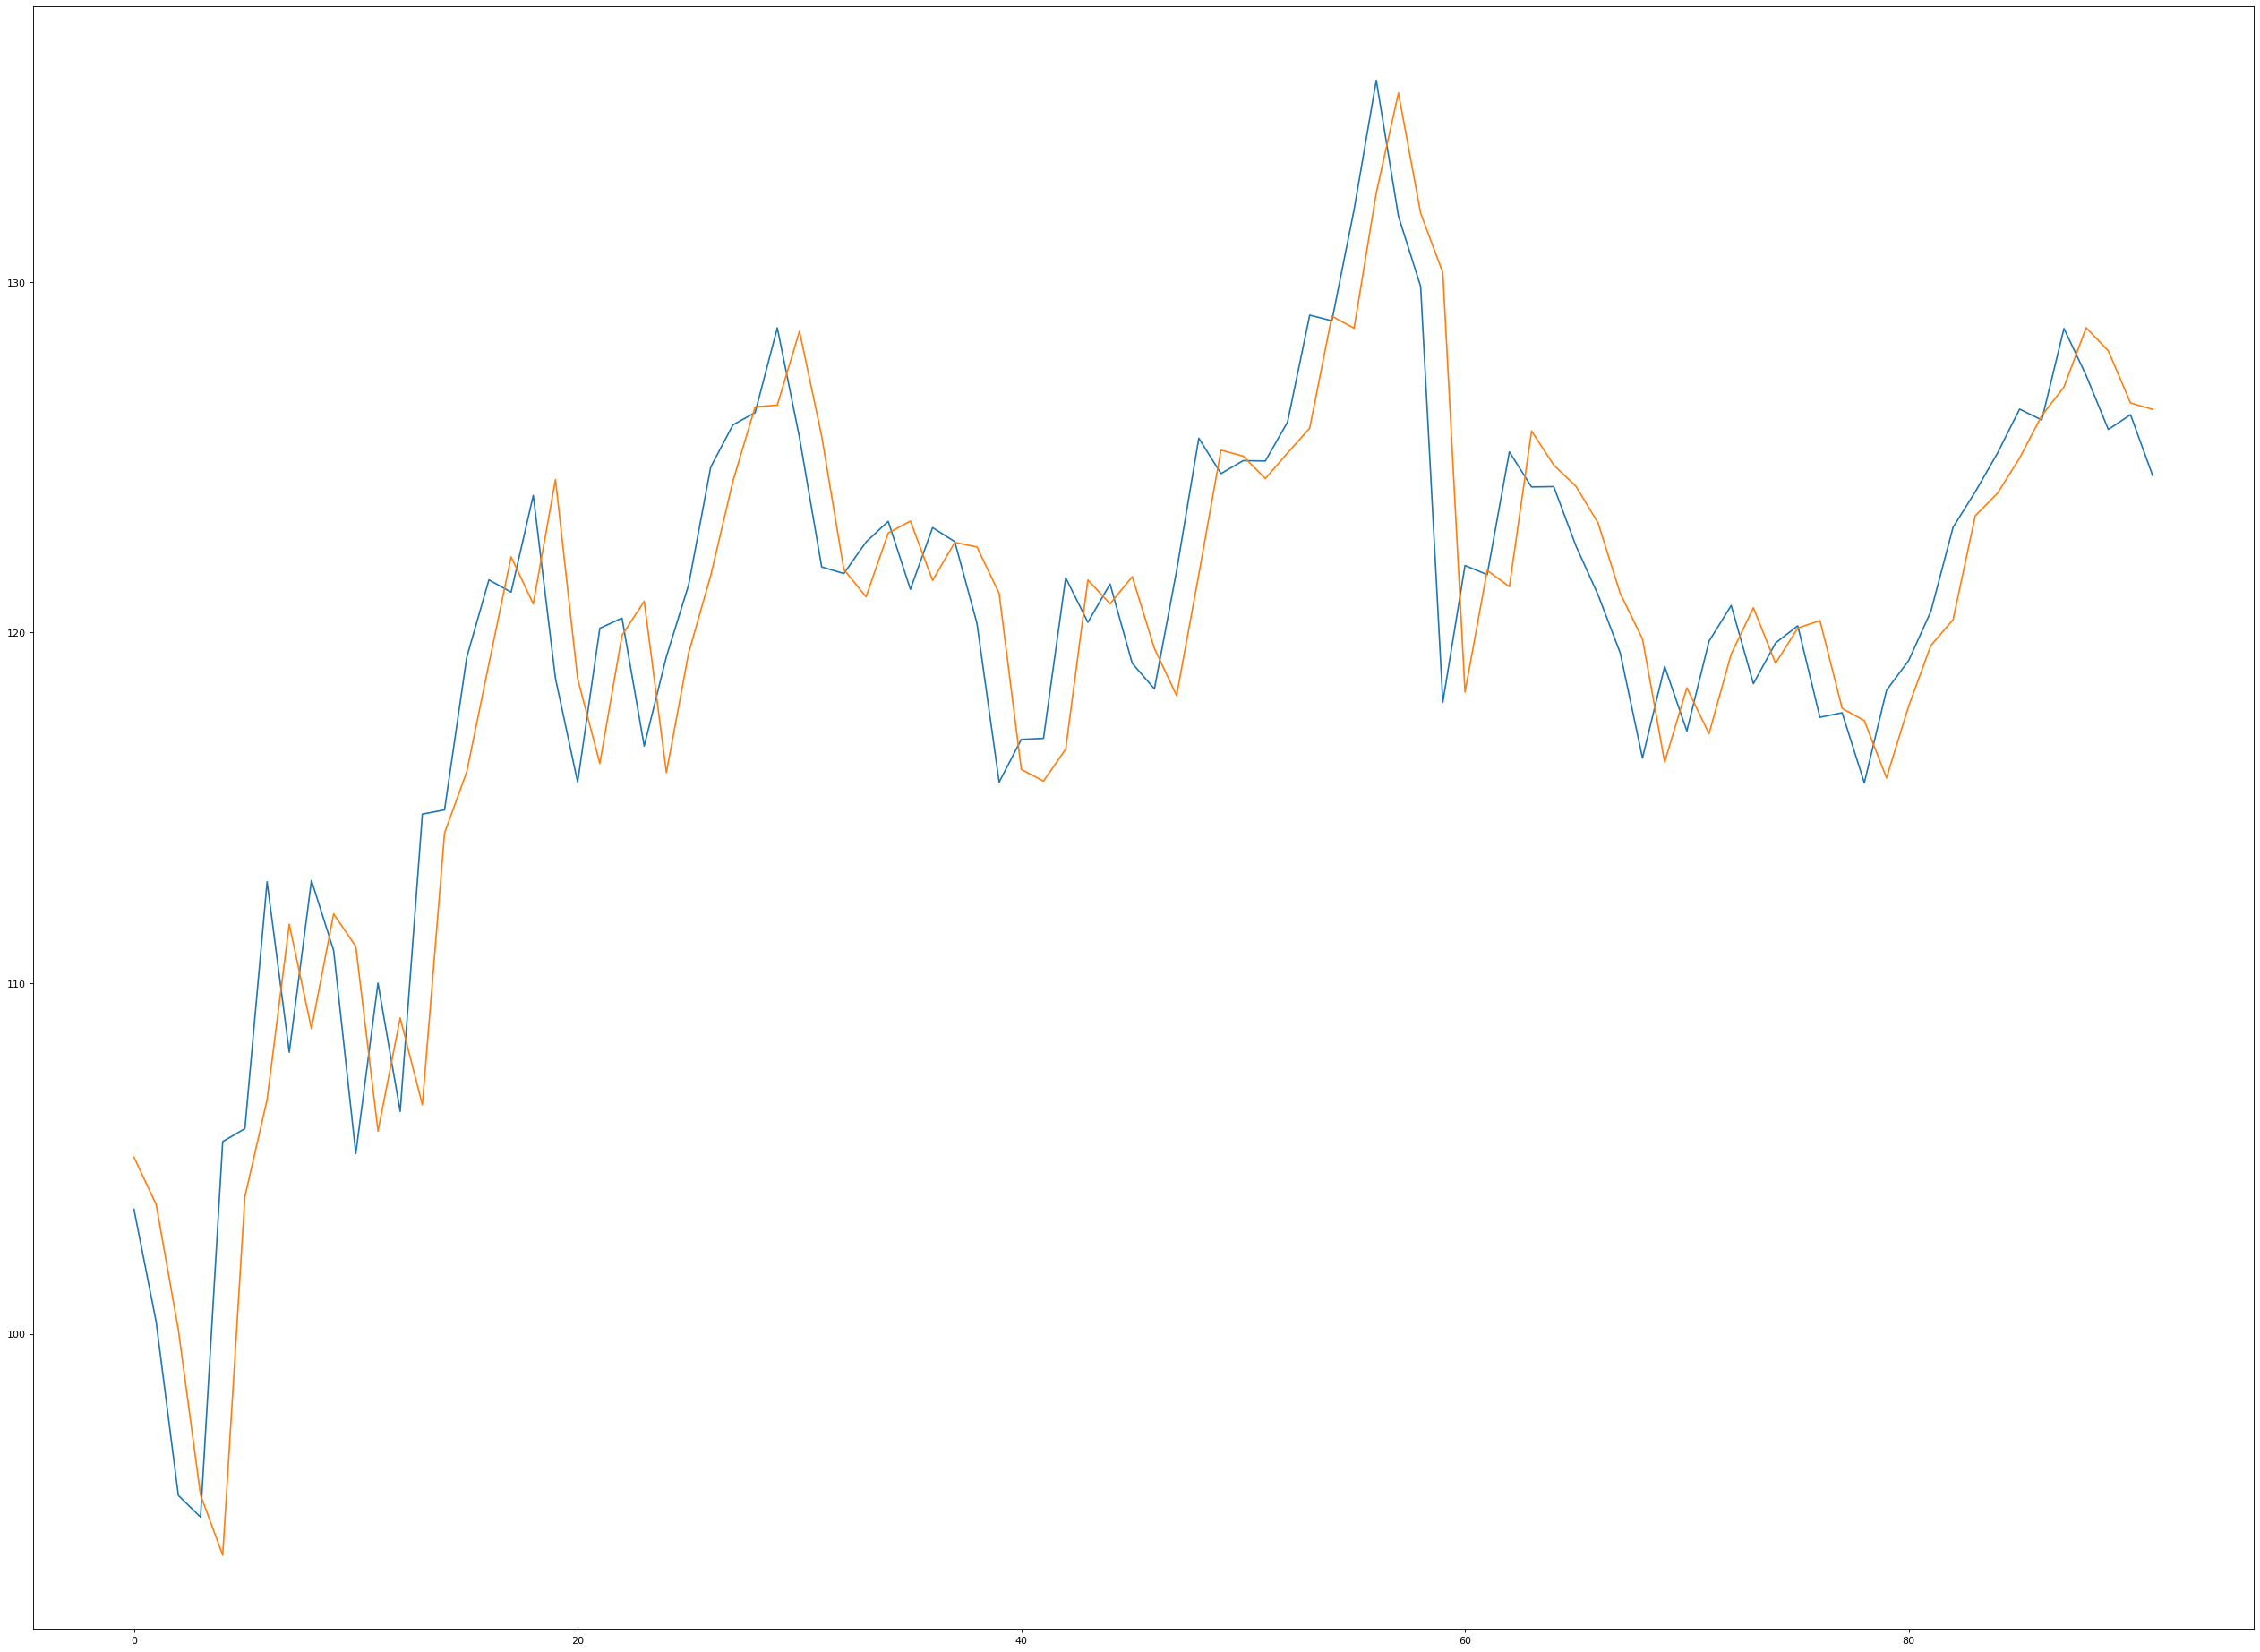

In [30]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), true_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()